# UNIVARIATE FORECASTING USING SIMPLE & DEEP RECURRENT NEURAL NETWORKS

_**Univariate time-series forcasting using Simple & Deep Recurrent Neural Networks (RNNs).**_

The following experiment considers Chicago Transit Authority (CTA) dataset (https://data.cityofchicago.org/) containing daily bus and rail ridership. The data from January 01, 2001 through August 1, 2024 was considered in this experiment.

In [1]:
# Imports required packages

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2026-01-24 03:23:57.636223: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-24 03:23:57.672951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-24 03:23:58.717284: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data Acquisition

In [2]:
# Loads the dataset
ridership = pd.read_csv(
    "data/CTA-Ridership-Daily_Boarding_Totals_20240829.csv", 
    parse_dates=["service_date"]  # Considers column as a date column if it contains date as text
)

# Shows the dataset
display(ridership.head())

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343


**Note:** Attribute value **W**, **A** ans **U** in column **day_type** represent **Weekday**, **Saturday** and **Sunday/Holiday**, respectively.

In [3]:
# Sets the column 'service_date' as index instead of default integer-based index
ridership.set_index("service_date", inplace=True)

In [7]:
# Write code to sorts dataset (in ascending order) by set index in the above step to make index monotonic
# by calling DataFrame's `sort_index` method passing argument `True` to its `inplace` parameter.
# [Note that it would be a requirement for slicing DataFrame with a datetime type based index.]
ridership.sort_index(inplace=True)

<Axes: xlabel='service_date'>

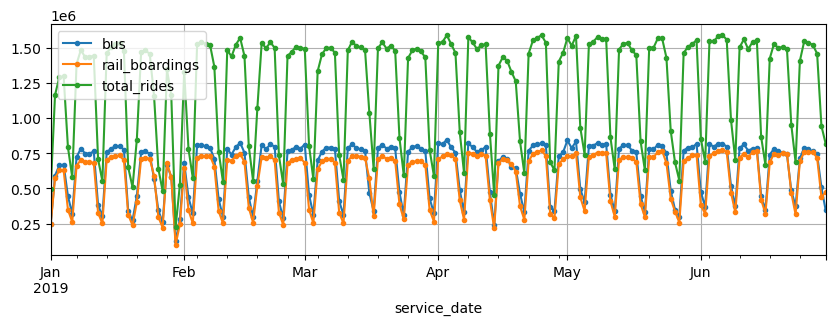

In [9]:
# Write code to drop the calculated column "total_rides" by calling DataFrame's `drop` method
# passing the name of the column as parameter. Also pass second axis i.e. 1 to its `axis`
# parameter to indicate deletion to take from which dimention, and `True` to its `inplace`
# parameter to make changes right in the same DataFrame instead returning another copy
# [Note that this column is not required for modeling as this is just element-wise addition
# between columns "bus" and "rail_boardings".]
ridership["2019-01":"2019-06"].plot(grid=True, marker=".", figsize=(10,3))

## Data Analysis

<Axes: xlabel='service_date'>

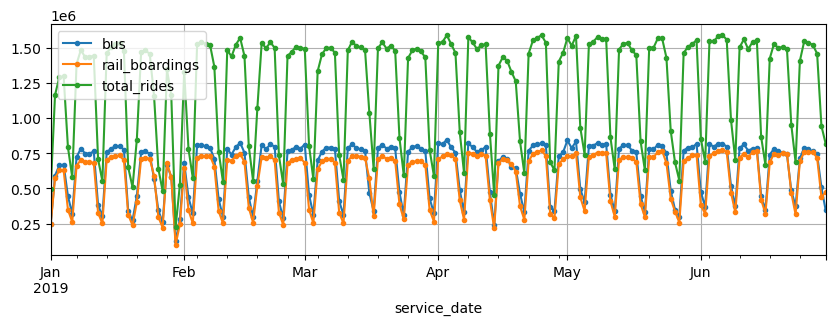

In [10]:
ridership["2019-01":"2019-06"].plot(grid=True, marker=".", figsize=(10, 3))


Look the the figure above and observe for any repeating patterns such as weekly seasonality for both variables - bus and rail.

## Data Preprocessing

**Prepares Datasets for Modeling**

Prepares input as sequences each containing 56 values from time steps (_t_ – 55) to _t_ for model to output a single value as a forecast for time step (_t_ + 1).

In [26]:
# Write code to split the DataFrame into three representing split for training, validation and testing, respectively.
# Train set should contain data from 2016-01 to 2018-12 (3 years).
# Validation set should contain data from 2019-01 to 2019-06 (6 months)
# Test set should contain data from 2019-07 onwards.
# Scale down all the features values from milions to between 0 and 1 by diving them by 1e6.
# Scaling should be done for all the sets.

rail_train =ridership["rail_boardings"]["2016-01":"2018-12"] / 1e6  # Write code
rail_val =ridership["rail_boardings"]["2019-01":"2019-06"] / 1e6  # Write code
rail_test = ridership["rail_boardings"]["2019-07":] / 1e6 # Write code

In [27]:
# Prepares TensorFlow specific datasets

seq_length = 56    # sequence of 56 days of ridership data on which prediction for next day is made on

tf.random.set_seed(42)  # Sets global random seed for operations that rely on a random seed

# Creates train set consists of sequences each containing 56 consecutive data points
rail_train_set = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),           # All consecutive data points (timesteps) converted from series to array
    targets=rail_train[seq_length:], # To set targets[i+seq_length]` as target corresponding to the window that starts at index `i`
    sequence_length=seq_length,      # Length of output sequence
    batch_size=32,                   # Number of sequences in each batch
    shuffle=True,                    # Shuffles the output sequences [required only for training]
    seed=42                          # Random seed for shuffling [required only if shuffling is set to True]
)

# Similarly, prepares validation and test set 
# (without shufflining as it is not required for validation and testing)

rail_val_set = tf.keras.utils.timeseries_dataset_from_array(
    rail_val.to_numpy(),
    targets=rail_val[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

rail_test_set = tf.keras.utils.timeseries_dataset_from_array(
    rail_test.to_numpy(),
    targets=rail_test[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

## Modeling
_Models univariate forecasting using simple and deep RNNs._

### Univariate Forecasting

_Forecasting next days's rail ridership based (only) on rail ridership [single variable as input] of the past 8 weeks (56 days)._

#### Forecasting Using a Simple RNN

In [28]:
# Creates a sequential model with an RNN
univar_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),  # None indicates RNN to accept input sequence of any length
    tf.keras.layers.SimpleRNN(32),           # Simple RNN layer with 32 output recurrent neurons
    tf.keras.layers.Dense(1)                 # Output layer with one output neuron
])

In [30]:
# Compiles it with specific loss function, optimizer and metric
univar_simple_rnn.compile(
    loss="huber",                     # Huber loss is popular for RNN for regression task
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=["mae"])

In [31]:
# Fits the model

# Write code to fit the model by calling `univar_simple_rnn.fit` and passing the following
# arguments to its parameters
# Rail train TensorFlow data set as the first parameter
# Rail validation TensorFlow data set to the parameter `validation_data`
# 500 to paramter `epochs`
# A list containing an `tf.keras.callbacks.EarlyStopping` object to parameter `callbacks`.
# Pass the following argumements to `tf.keras.callbacks.EarlyStopping` to initialize.
# "val_mae" to `monitor` (to check for a specific metric).
# 50 to `patience` (to wait before stopping traning if validation performance does not improve)
# `True` to `restore_best_weights` (to return best performing model)

history =univar_simple_rnn.fit(
    rail_train_set,
    validation_data=rail_val_set,
    epochs=500,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_mae",
            patience=50,
            restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0383 - mae: 0.2095 - val_loss: 0.0062 - val_mae: 0.0950
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - mae: 0.0831 - val_loss: 0.0045 - val_mae: 0.0746
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - mae: 0.0682 - val_loss: 0.0027 - val_mae: 0.0508
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - mae: 0.0613 - val_loss: 0.0024 - val_mae: 0.0445
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - mae: 0.0561 - val_loss: 0.0030 - val_mae: 0.0533
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - mae: 0.0545 - val_loss: 0.0027 - val_mae: 0.0505
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0022 - val_mae: 0.0417
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0517 - val_loss: 0.0026 - val_mae: 0.0517
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.003

In [33]:
# After training, model gets evaluated against validation set

# Write code to pass rail TensorFlow  validation data set to `univar_simple_rnn.evaluate` to get
# validation performance over loss and MSE.

val_loss, val_mae =univar_simple_rnn.evaluate(rail_val_set)

print(f"\nValidation loss: {val_loss * 1e6:.4f}, MAE of the Simple RNN: {val_mae * 1e6:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mae: 0.0288     

Validation loss: 1523.0022, MAE of the Simple RNN: 28764.6148


#### Forecasting Using a Deep RNN

Now, checks if deep RNN (multiple layers of Simple RNN) works better than simple RNN.

In [34]:
tf.keras.backend.clear_session()    # Resets all the keras states

tf.random.set_seed(42)

# Creates a Deep RNN with multiple layers of simple RNN each with 32 recurrent neurons 
# followed by a dense output layer with one output neuron
univar_deep_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),  # sequence-to-sequence layer
    tf.keras.layers.SimpleRNN(32, return_sequences=True),  # sequence-to-sequence layer
    tf.keras.layers.SimpleRNN(32),                         # sequence-to-vector layer
    tf.keras.layers.Dense(1)
])

In [35]:
# Compiles the model

# Write code to compile the model `univar_deep_rnn` referring to the same 
# instruction provided above. Arguments will remain the same.

univar_deep_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=["mae"])

In [36]:
# Fits the model

# Write code to fit the model `univar_deep_rnn` referring to the same 
# instruction provided above. Arguments will remain the same.

history =univar_deep_rnn.fit(
    rail_train_set,
    validation_data=rail_val_set,
    epochs=500,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_mae",patience=50, restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0368 - mae: 0.1934 - val_loss: 0.0136 - val_mae: 0.1539
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0125 - mae: 0.1291 - val_loss: 0.0077 - val_mae: 0.0957
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0091 - mae: 0.1013 - val_loss: 0.0040 - val_mae: 0.0724
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - mae: 0.0848 - val_loss: 0.0045 - val_mae: 0.0740
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - mae: 0.0738 - val_loss: 0.0030 - val_mae: 0.0585
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - mae: 0.0631 - val_loss: 0.0039 - val_mae: 0.0695
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - mae: 0.0638 - val_loss: 0.0023 - val_mae: 0.0455
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0043 - mae: 0.0595 - val_loss: 0.0029 - val_mae: 0.0535
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

In [39]:
# After training, model gets evaluated against validation data

# Write code to evaluate the model `univar_deep_rnn` referring to the same 
# instruction provided above. Arguments will remain the same.

val_loss, val_mae = univar_deep_rnn.evaluate(rail_val_set)


print(f"\nValidation loss: {val_loss * 1e6:.4f}, MAE of the Deep RNN: {val_mae * 1e6:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - mae: 0.0290    

Validation loss: 1537.0419, MAE of the Deep RNN: 28989.5087


Compare the validation perform of these two models. In the next experiment, multivariate forecasting explored to check if it can improve model performance further.

## Observation

- How was the date column processed to set it as index in the DataFrame? What was the reason to have date column as index instead of default index?

- What were the observation from the ploting of the time-series for bus and rail ridership?

- How was DataFrame split to prepare training, validation and test data set?

- Target window for how many days was considered for next day's prediction to be made?

- Why was TensorFlow data set used as data loader for model training? What process was followed to prepare these data sets?

- Which loss function was used and why? How was early stopping configured?

- Analyze the prediction performance of these two models.